**Explanation**

## User-Agnostic Item Ranking Algorithm

This notebook implements a user-agnostic item ranking algorithm that aims to find a robust average rating for each item, filtering out potential outliers. The goal is to provide a reliable item ranking that is not biased by individual user variations.

### **How it Works**

1.  **Load Dataset:** The notebook begins by loading a tab-separated dataset containing user-item ratings, including a "normalized\_rating" column.
2.  **Iterate Through Items:** The algorithm then iterates through each unique item in the dataset.
3.  **Iterative Mean Filtering:** For each item, it performs an iterative process:
    * Calculate the mean and standard deviation of the item's ratings.
    * Filter out ratings that deviate significantly (more than one standard deviation) from the mean.
    * Repeat until no more ratings are filtered out (convergence).
4.  **Compute Final Ranking:** The final ranking for each item is determined by the mean of the remaining (filtered) ratings.
5.  **Visualize Results:** The notebook then creates a histogram to visualize the distribution of the calculated item rankings.

### **This notebook will:**

* Load a tab-separated dataset containing user-item ratings.
* Implement a user-agnostic item ranking algorithm.
* Generate a histogram showing the distribution of the resulting item rankings.
* Filter outliers from item ratings to get a more robust mean.

**1.  Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

**2.    Load Dataset**

In [2]:
# Define dataset path
file_path = "/home/martimsbaltazar/Desktop/tese/datasets/ml-1m/normalized_ratings.dat"

# Load dataset
df = pd.read_csv(file_path, sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp", "NormalizedRating"])

# Display first few rows
df.head()

,UserID,MovieID,Rating,Timestamp,NormalizedRating
0,1,1193,5,978300760,1.0
1,1,661,3,978302109,0.6
2,1,914,3,978301968,0.6
3,1,3408,4,978300275,0.8
4,1,2355,5,978824291,1.0


**3. User-Agnostic Bipartite ranking computation**

In [3]:
def user_agnostic_ranking(tol=1e-6):
    
    # Step 2: Define output dictionary for item rankings
    item_rankings = {}

    # Step 3: Iterate over all unique items
    for item, ratings in df.groupby("MovieID")["NormalizedRating"]:
        ratings = list(ratings)  # Convert to list
        converged = False

        # Step 5: Loop until a fixed point is reached
        while not converged:
            # Step 6: Compute the mean (μᵢ) of ratings for item i
            μ_i = np.mean(ratings)
            
            # Step 7: Compute the standard deviation (σᵢ)
            σ_i = np.std(ratings) if len(ratings) > 1 else 0

            # Step 8: Filter out ratings that deviate significantly from the mean
            new_ratings = [r for r in ratings if (r - μ_i) ** 2 <= σ_i]

            # Step 9: Check for convergence (if no ratings were removed)
            converged = (len(new_ratings) == len(ratings))

            #step 10: Update the ratings
            ratings = new_ratings
        
        # Step 12: Compute the final ranking as the mean of the filtered ratings
        item_rankings[item] = np.mean(ratings)

    return item_rankings

**4.    Compute item rankings**

In [4]:
# Compute rankings using the bipartite ranking algorithm
rankings = user_agnostic_ranking(df)

# Display top-ranked items
sorted_rankings = sorted(rankings.items(), key=lambda x: x[1], reverse=True)
sorted_rankings[:10]


[(787, 1.0),
 (989, 1.0),
 (1420, 1.0),
 (1830, 1.0),
 (3172, 1.0),
 (3233, 1.0),
 (3280, 1.0),
 (3382, 1.0),
 (3607, 1.0),
 (3656, 1.0)]

**5. Visualizing the Distribution of Item Rankings**

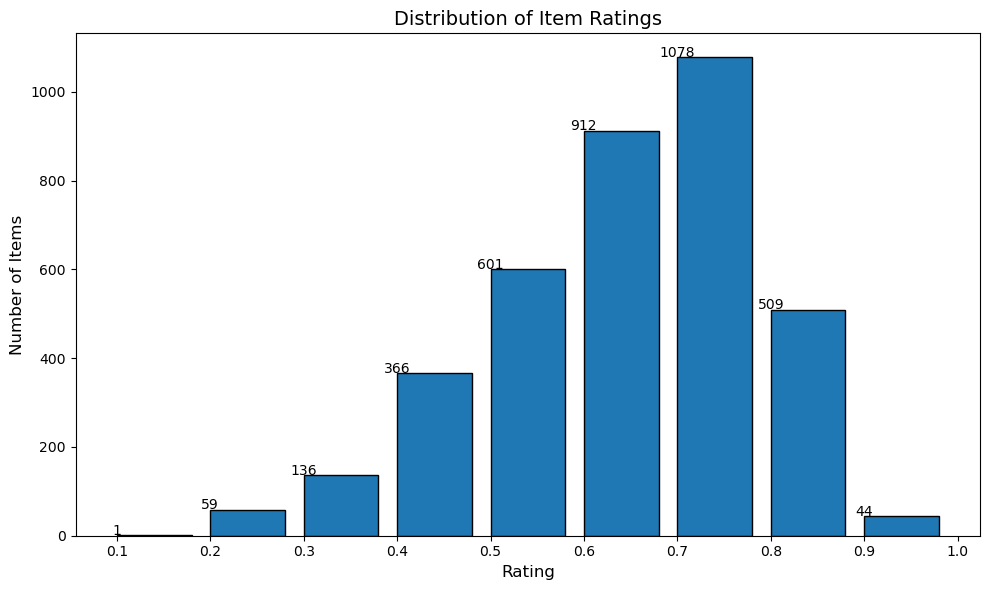

In [5]:
# Extract the ratings from the rankings
ratings = list(rankings.values())

# Define bins for the ratings (from 0.1 to 1.0 with steps of 0.1)
bins = np.arange(0.1, 1.1, 0.1)

# Count how many items fall into each rating bin
hist, bin_edges = np.histogram(ratings, bins=bins)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=0.08, align='edge', edgecolor='black')

# Adding numbers on top of bars
for i in range(len(hist)):
    plt.text(bin_edges[i], hist[i] + 1, str(hist[i]), ha='center', fontsize=10)

# Finalize the plot
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.title('Distribution of Item Ratings', fontsize=14)
plt.xticks(bins)  # Ensure the x-ticks correspond to the rating bins
plt.tight_layout()
plt.show()


**6. Metrics**


**6.1 Effectiveness**

In [6]:
def compute_aggregated_average_ranking(df):
    return df.groupby("MovieID")["NormalizedRating"].mean().to_dict()

def compute_kendall_tau(ranking_1, ranking_2):
    common_items = set(ranking_1.keys()) & set(ranking_2.keys())  # Ensure only common items are compared
    
    if len(common_items) < 2:  # Need at least two rankings to compute Kendall's tau
        return 0
    
    sorted_items = sorted(common_items)  # Sort items to ensure consistent order
    
    list_1 = [ranking_1[item] for item in sorted_items]
    list_2 = [ranking_2[item] for item in sorted_items]
    
    return kendalltau(list_1, list_2).correlation

# Compute the aggregated average ranking
aa_rankings = compute_aggregated_average_ranking(df)

# Compute Kendall’s tau for the entire dataset
tau_value = compute_kendall_tau(rankings, aa_rankings)
print(f"Kendall’s τ: {tau_value:.4f}")



Kendall’s τ: 0.9542


**6.2   Bias**